In [1]:
import kmodels as kmk
import torch 
import numpy as np
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt


In [14]:
# lets generate an array of n observations with 50 features being random binary numbers and 50 features being random floats
n = 1000
plot_points = 100
# set binary_dim to zero if you have no binary features
binary_dim = 1
n_features = 4
x = np.random.randint(2, size=(n, binary_dim))
x = np.concatenate((x, np.random.normal(size=(n, n_features-binary_dim))), axis=1)
# lets make up a correlated but complicated y variable. make sure y is 1 feature
# y = np.convolve(x[:, binary_dim:], np.random.normal(size=binary_dim), mode='same') * np.mean(x[:, :binary_dim ]) + np.random.normal(size=binary_dim)
#y = y.reshape(-1, 1)
# assign random weights to the binary features
# make the weights a distribution of only two values
weights = np.random.randint(2, size=(n_features-binary_dim))

y = np.trapz(x[:, :binary_dim], axis=1).reshape(-1, 1) 
print(x[:, :binary_dim].shape, weights.shape, y.shape)
y2 = np.sum(x[:, :binary_dim] * weights, axis=1).reshape(-1, 1)
y = y.reshape(-1, 1)

# scale the features
# use minmax scaler on binary dim and standard scaler on float dim
x_bin = MinMaxScaler().fit_transform(x[:, :binary_dim])
x_float = StandardScaler().fit_transform(x[:, binary_dim:])
x = np.concatenate((x_bin, x_float), axis=1)
#x = np.concatenate((x, y), axis=1)
x = torch.tensor(x, dtype=torch.float32)
# plot as a 10x10 image 
px.imshow(x[:100].numpy(), width=500, height=500)


(1000, 1) (3,) (1000, 1)


Text(0.5, 1.0, 'Histogram of features')

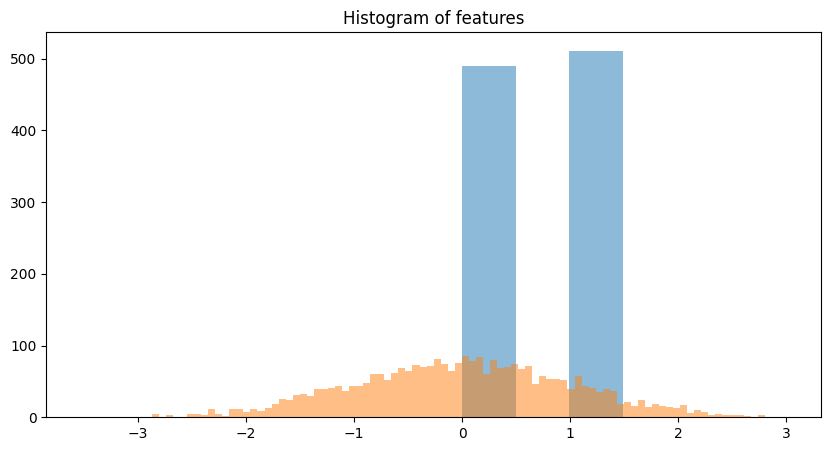

In [15]:
# plot the histograms of all the features
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# make the bars larger
ax.hist(x[:, :binary_dim].numpy().flatten(), bins=100, alpha=0.5, label='binary', width=0.5)
ax.hist(x[:, binary_dim:].numpy().flatten(), bins=100, alpha=0.5, label='float')
plt.title('Histogram of features')


In [16]:
#params = {'hidden_dim':[50, 100, 200], 'latent_dim':[2, 5, 10], 'n_layers':[5, 10, 20], 'beta':[1, 10, 100], 'gamma':[1, 10, 100]}
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# lets wrap the Training class and the model into a function that will be compatible with sklearn's GridSearchCV
class VSECA(kmk.Training):
    def __init__(self, batch_size=100, epochs=1000, lr_init=1e-3, binary_dim=10, hidden_dim = 100, beta=1, 
                 gamma=1, input_dim=100, latent_dim=2, n_layers=5, metric=r2_score, y=None, device='cuda', scheduler=True,
                 reg_factor=1):
        
        kwargs = locals()
        # super the kmk.Training class for VSECA
        self.batch_size = batch_size
        self.lr_init = lr_init
        self.binary_dim = binary_dim
        self.hidden_dim = hidden_dim
        self.beta = beta
        self.gamma = gamma
        self.latent_dim = latent_dim
        self.n_layers = n_layers
        self.input_dim = input_dim
        self.metric = metric
        self.y = y
        
        if y is not None:
            self.y = torch.tensor(y, dtype=torch.float32).to(device)

        for key in kwargs:
            setattr(self, key, kwargs[key])

        param_vars = ['epochs','batch_size', 'lr_init', 'binary_dim', 'hidden_dim', 'beta', 'gamma', 'latent_dim', 'n_layers', 'input_dim', 'reg_factor']

        self.params = {}
        for att in param_vars:
            self.params[att] = getattr(self, att)

        self.model_params = {'hidden_dim':hidden_dim, 'latent_dim':latent_dim, 'n_layers':n_layers, 'input_dim':input_dim, 'formula_dim':binary_dim}
        self.training_params = {}

        for param in self.params:
            if param in self.model_params.keys():
                self.model_params[param] = self.params[param]
            else:
                self.training_params[param] = self.params[param]

        self.model = kmk.VAE(**self.model_params).to(self.device)
        self.Training = kmk.Training(self.model, x, y, vae_loss=True, **self.training_params, scheduler=scheduler)

        self._get_losses = self.Training._get_losses
        
    def fit(self, x, y):
        self.model_params['input_dim'] = x.shape[1]
        self.model = kmk.VAE(**self.model_params).to(self.device)
        super(VSECA, self).__init__(self.model, x, y, vae_loss=True, **self.training_params)
        if type(x) == np.ndarray:
            x = torch.tensor(x, dtype=torch.float32).to(self.device)
        if type(y) == np.ndarray:
            y = torch.tensor(y, dtype=torch.float32).to(self.device)
        self.Training = kmk.Training(self.model, x, y, vae_loss=True, **self.training_params)
        self.Training.train()
        return self
    
    def predict(self, x):
        return self.model(x)[0].detach().cpu()
    
    def score(self, x, y):
        # mae of x and y
        # make sure x and y are torch tensors
        if type(x) == np.ndarray:
            x = torch.tensor(x, dtype=torch.float32).to(self.device)
        else:
            x = x.to(self.device)
        pred = self.model(x)[0].detach().cpu().numpy()
        if type(y) == np.ndarray:
            pass
        else:
            y.detach().cpu().numpy()
        return self.metric(y, pred)
    
    def get_params(self, deep=True):
        return self.params
    
    def set_params(self, **params):
        self.params.update(params)
        # update the attributes
        for param in self.params:
            setattr(self, param, self.params[param])
        # update the model and trainer
        for param in params:
            if param in self.model_params.keys():
                self.model_params[param] = params[param]
            if param not in self.model_params.keys():
                self.training_params[param] = params[param]
        self.model = kmk.VAE(**self.model_params)
        self.Training = kmk.Training(self.model, x, y, vae_loss=True, **self.training_params)
        return self

    

In [17]:
v = VSECA(lr_init=5e-4, epochs=10001, hidden_dim=100, n_layers=5, batch_size=100, 
          latent_dim=2, y=y, device='cuda', reg_factor=0, beta=0, gamma=0,
          scheduler=True)
v.fit(x, x)

====> Epoch: 0 Average loss: 0.000135013 Time: 0.14
Loss components:  {'vae_loss': 0.00022466123}
====> Epoch: 10 Average loss: 0.000000030 Time: 0.10
Loss components:  {'vae_loss': 2.461672e-07}
====> Epoch: 20 Average loss: 0.000000014 Time: 0.09
Loss components:  {'vae_loss': 1.4528632e-07}
====> Epoch: 30 Average loss: 0.000000009 Time: 0.09
Loss components:  {'vae_loss': 8.955598e-08}
====> Epoch: 40 Average loss: 0.000000007 Time: 0.10
Loss components:  {'vae_loss': 6.3329935e-08}
====> Epoch: 50 Average loss: 0.000000005 Time: 0.11
Loss components:  {'vae_loss': 5.0961972e-08}
====> Epoch: 60 Average loss: 0.000000005 Time: 0.09
Loss components:  {'vae_loss': 4.440546e-08}
====> Epoch: 70 Average loss: 0.000000004 Time: 0.08
Loss components:  {'vae_loss': 3.963709e-08}
====> Epoch: 80 Average loss: 0.000000003 Time: 0.10
Loss components:  {'vae_loss': 3.710389e-08}
====> Epoch: 90 Average loss: 0.000000003 Time: 0.09
Loss components:  {'vae_loss': 2.6524066e-08}
====> Epoch: 100

KeyboardInterrupt: 

(-0.12084625826365902,
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: False
     lr: 0.0005
     maximize: False
     weight_decay: 0
 ))

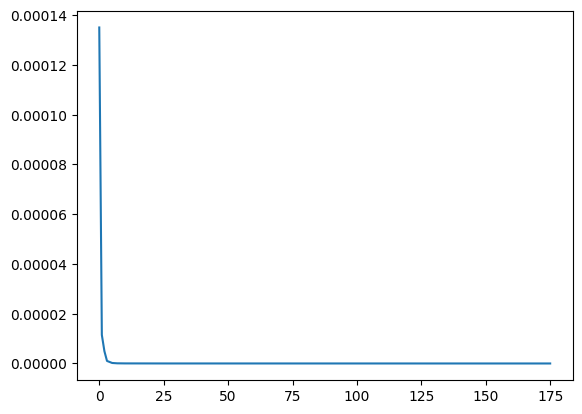

In [18]:
# plot the loss curves
plt.plot(v.Training.losses, label='loss')
v.score(x, x), v.Training.optimizer

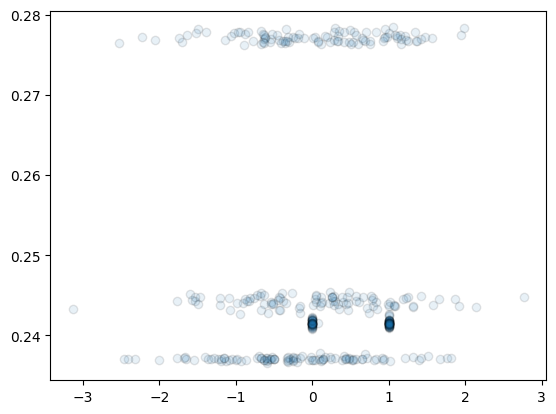

In [19]:
# parity plot
plt.scatter(x[0:plot_points], v.predict(x[0:plot_points]), alpha=0.1, edgecolor='k')

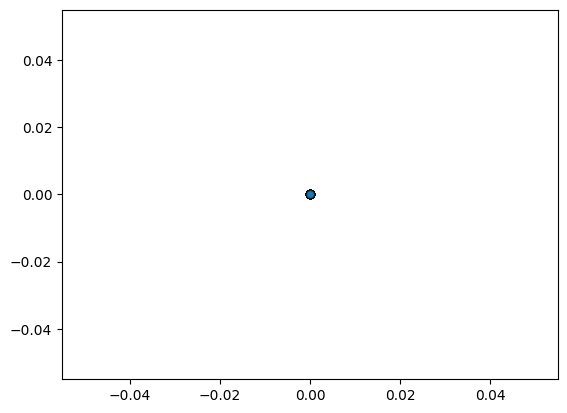

In [20]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
z = v.model.encode(x)[0].detach().cpu().numpy()
reg.fit(z, y)
pred = reg.predict(z)
pred.shape,y.shape
plt.scatter(y, pred, alpha=0.1, edgecolor='k')

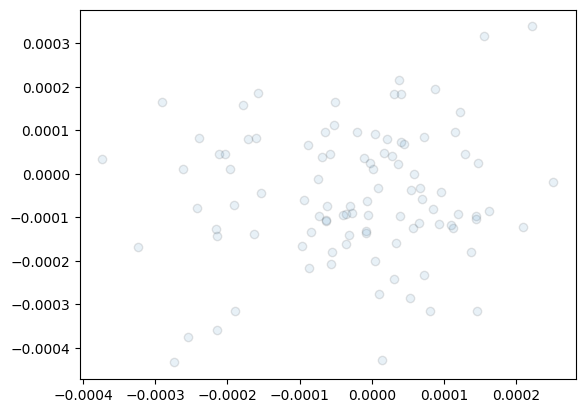

In [21]:
# latent space
plt.scatter(v.model.encode(x[0:plot_points])[0][:,0].detach().cpu().numpy(), v.model.encode(x[0:plot_points])[0][:,1].detach().cpu().numpy(), alpha=0.1, edgecolor='k')

In [22]:
recon_x, mu, logvar = v.model(x)
recon_x = recon_x.detach().cpu().numpy()
# plot as a 10x10 image 
px.imshow(recon_x[:100], width=500, height=500)

In [23]:
# random search cv
from sklearn.model_selection import RandomizedSearchCV
params = {'hidden_dim':[50, 100, 200], 'lr_init':[1e-3, 1e-4, 1e-5], 'n_layers':[5, 10, 20], 'beta':[1, 10, 100], 'gamma':[1, 10, 100]}
rand_cv = RandomizedSearchCV(VSECA(epochs=101, device='cuda'), params, n_iter=10, cv=5, verbose=1, n_jobs=1)
rand_cv.fit(x, x)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\efons\anaconda3\envs\venv\lib\site-packages\kmodels\utils.py:324: UserWarning:

Using a target size (torch.Size([800, 4])) that is different to the input size (torch.Size([100, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

c:\Users\efons\anaconda3\envs\venv\lib\site-packages\kmodels\utils.py:324: UserWarning:

Using a target size (torch.Size([800, 4])) that is different to the input size (torch.Size([100, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

c:\Users\efons\anaconda3\envs\venv\lib\site-packages\kmodels\utils.py:324: UserWarning:

Using a target size (torch.Size([800, 4])) that is different to the input size (torch.Size([100, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

c:\Users\efons\anaconda3\envs\venv\lib\site-packages\kmodels\utils.py:324: UserWarning:

Using a target size (to

ValueError: 
All the 50 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\efons\anaconda3\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\efons\AppData\Local\Temp\ipykernel_19572\3087644749.py", line 58, in fit
    self.Training.train()
  File "c:\Users\efons\anaconda3\envs\venv\lib\site-packages\kmodels\utils.py", line 400, in train
    train_loss = self.train_epoch(epoch)
  File "c:\Users\efons\anaconda3\envs\venv\lib\site-packages\kmodels\utils.py", line 413, in train_epoch
    loss += self.compute_additional_losses(recon_batch, data, batch_idx)
  File "c:\Users\efons\anaconda3\envs\venv\lib\site-packages\kmodels\utils.py", line 447, in compute_additional_losses
    regression_loss = self.regression_loss(z, self.y, batch_idx)
  File "c:\Users\efons\anaconda3\envs\venv\lib\site-packages\kmodels\utils.py", line 324, in __call__
    self.reg_loss.append(F.mse_loss(torch.from_numpy(y_pred), y))
  File "c:\Users\efons\anaconda3\envs\venv\lib\site-packages\torch\nn\functional.py", line 3291, in mse_loss
    expanded_input, expanded_target = torch.broadcast_tensors(input, target)
  File "c:\Users\efons\anaconda3\envs\venv\lib\site-packages\torch\functional.py", line 74, in broadcast_tensors
    return _VF.broadcast_tensors(tensors)  # type: ignore[attr-defined]
RuntimeError: The size of tensor a (100) must match the size of tensor b (800) at non-singleton dimension 0


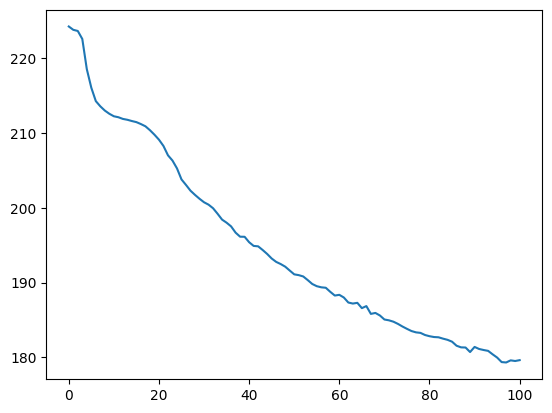

In [ ]:
plt.plot(rand_cv.best_estimator_.Training.losses, label='loss')